In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from keras_tuner import Hyperband
from keras_tuner import Objective, HyperParameters
from tensorboard.backend.event_processing import event_accumulator
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

import shap
import os

# 1. Explorative Data Analysis

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [4]:
df.shape

(299, 13)

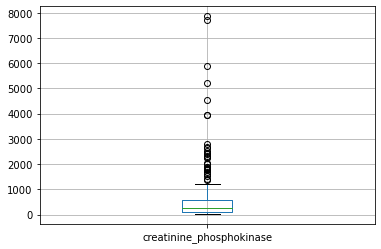

In [5]:
df.boxplot(column = ['creatinine_phosphokinase']);

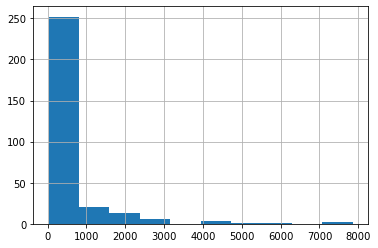

In [6]:
df.creatinine_phosphokinase.hist();

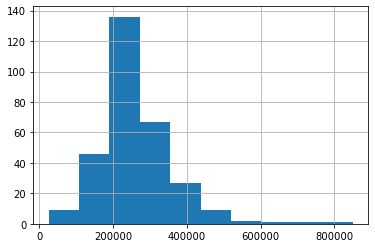

In [7]:
df.platelets.hist();

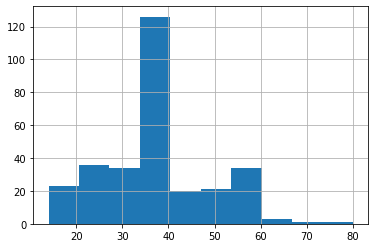

In [8]:
df.ejection_fraction.hist();

In [9]:
df_corr=df[['age','serum_creatinine','time','ejection_fraction','serum_sodium','DEATH_EVENT']]

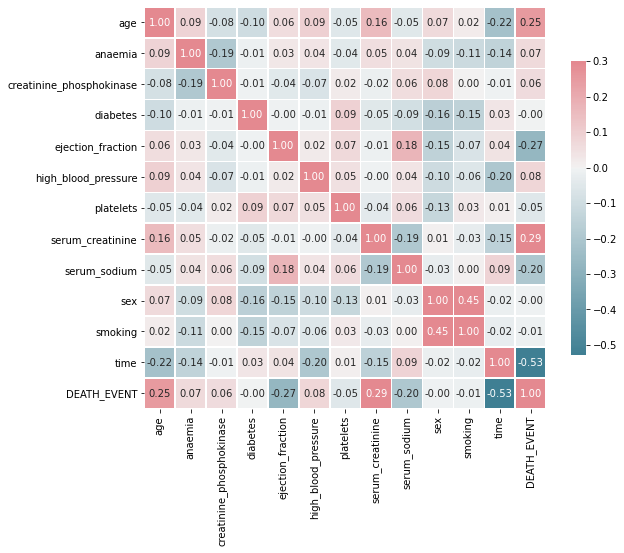

In [10]:
plt.subplots(figsize=(9,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(),vmax=.3, annot=True,center=0, cmap=cmap, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .6});

In [11]:
#correlationsmatrix mit relevanten features, ie. |corr|>0.2
#age, ejection_fraction, serum_creatinine, serum_sodium, time

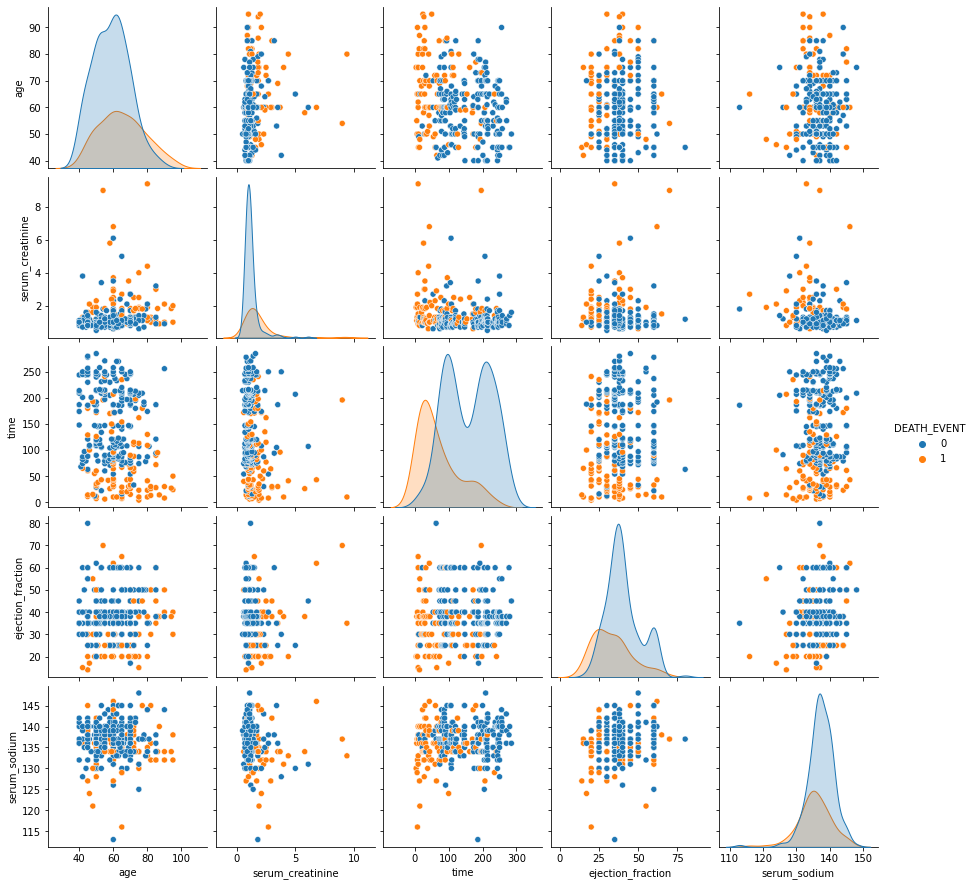

In [12]:
sns.pairplot(df,vars=df[['age','serum_creatinine','time','ejection_fraction','serum_sodium']], diag_kind='kde', hue='DEATH_EVENT');

# 2. Preprocessing

In [13]:
target = df.pop('DEATH_EVENT')
df.pop('time')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0


Preprocessing: 
1.Split data into train/val set
2.standardize train set and apply train mean and std on val set
3.(optional) apply PCA on the train set and transform val set with pc of train set 
4.(optional) apply SMOTE on train set

In [14]:
##split
X_train, X_val, y_train, y_val = train_test_split(df,target, test_size=0.3,random_state=3)

##standardize (around 71% acc on val set)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

##pca (around 76% acc on val set)
pca = PCA(n_components=5)
X_train_pca = pd.DataFrame(data = pca.fit_transform(X_train), columns=['pc1','pc2','pc3','pc4','pc5'])
X_val_pca=pd.DataFrame(data = pca.transform(X_val), columns=['pc1','pc2','pc3','pc4','pc5'])


#smote (around 80% acc on val set)
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)




In [15]:
X_train

array([[ 2.50062217,  1.11683115, -0.21921339, ...,  1.59208092,
        -1.37941211, -0.66436384],
       [-0.08210945,  1.11683115,  0.05179574, ...,  0.27601667,
         0.72494651,  1.50519932],
       [-0.08210945, -0.89539049,  1.71197759, ..., -0.16267142,
         0.72494651, -0.66436384],
       ...,
       [-0.08210945,  1.11683115,  0.52857106, ..., -1.25939163,
         0.72494651, -0.66436384],
       [-0.68474682, -0.89539049, -0.34969927, ..., -1.47873567,
        -1.37941211, -0.66436384],
       [-0.94301998, -0.89539049, -0.44204312, ..., -0.6013595 ,
         0.72494651,  1.50519932]])

In [16]:
print(pca.singular_values_)
print(pca.explained_variance_ratio_)
print(X_train_pca.head())

[18.23693857 16.88043306 16.47876999 15.42588398 14.74438833]
[0.14466548 0.12394477 0.11811651 0.10350496 0.09456154]
        pc1       pc2       pc3       pc4       pc5
0 -1.840885  1.088920 -1.339657  0.883097  0.863393
1  1.400165  0.036419 -1.222825 -0.809946  0.860593
2  0.633673 -0.796352  0.145238  1.026821 -1.703849
3  1.632444 -1.772448 -1.186495  0.001019  0.947523
4  0.464405  0.489814 -2.209480  0.123286  1.800221


# 3. Neural Net

In [17]:
#create dataset
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(len(X_train))
#val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(len(X_val))

In [18]:
#add batch size as hyperparameter by overwriting run_trial method
class MyTuner(kt.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', [4,8,16,32,64,128])
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [19]:
def model_builder(hp):
    model = keras.Sequential([
    keras.layers.Dense(hp.Choice("units_l1", [4,8,16,32]), kernel_initializer = 'uniform', activation='relu',input_dim = 11),
    keras.layers.Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.05)),
    keras.layers.Dense(hp.Choice("units_l2", [4,8,16,32]), kernel_initializer = 'uniform', activation = 'relu'),
    keras.layers.Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.05)),
    keras.layers.Dense(hp.Choice("units_l3", [4,8,16,32]), kernel_initializer = 'uniform', activation='relu'),
    keras.layers.Dropout(hp.Float('dropout_3', 0.1, 0.5, step=0.05)),
    keras.layers.Dense(1,activation='sigmoid')
  ])

    model.compile(optimizer=keras.optimizers.Adam(lr=hp.Float('lr',0.0001,0.01,0.0002)),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [20]:
#need logs directory to save and access accuracy and loss returned from Tensorboard callback
log_dir = "logs/" 
tuner = MyTuner(hypermodel = model_builder, objective = Objective('val_accuracy', direction='max'), max_trials = 50, project_name="hyperparameter_tuning")


tuner.search(X_train, y_train, validation_data=(X_val,y_val), epochs=100 ,callbacks=[keras.callbacks.TensorBoard(log_dir),keras.callbacks.EarlyStopping('val_loss', patience=5)])


Trial 50 Complete [00h 00m 11s]
val_accuracy: 0.7333333492279053

Best val_accuracy So Far: 0.7666666507720947
Total elapsed time: 00h 09m 37s
INFO:tensorflow:Oracle triggered exit


In [21]:
#to reload from file instantiate tuner and then simply reload tuner without tuner.search()
#tuner.reload()


In [22]:
best_model =tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
tuner.results_summary()


Results summary
Results in .\hyperparameter_tuning
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units_l1: 32
dropout_1: 0.1
units_l2: 32
dropout_2: 0.30000000000000004
units_l3: 32
dropout_3: 0.5000000000000001
lr: 0.0001
batch_size: 4
Score: 0.7666666507720947
Trial summary
Hyperparameters:
units_l1: 32
dropout_1: 0.1
units_l2: 4
dropout_2: 0.1
units_l3: 32
dropout_3: 0.5000000000000001
lr: 0.005500000000000001
batch_size: 4
Score: 0.7666666507720947
Trial summary
Hyperparameters:
units_l1: 4
dropout_1: 0.1
units_l2: 32
dropout_2: 0.1
units_l3: 32
dropout_3: 0.1
lr: 0.0001
batch_size: 4
Score: 0.7555555701255798
Trial summary
Hyperparameters:
units_l1: 32
dropout_1: 0.1
units_l2: 4
dropout_2: 0.1
units_l3: 32
dropout_3: 0.5000000000000001
lr: 0.0001
batch_size: 4
Score: 0.7555555701255798
Trial summary
Hyperparameters:
units_l1: 32
dropout_1: 0.1
units_l2: 4
dropout_2: 0.5000000000000001
units_l3: 32
dropout_3: 0.500000000000000

In [38]:
def plot_loss(history):
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.title('Training and Validation Loss')
    #plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
def plot_acc(history):
    plt.plot(history['accuracy'], label='train acc')
    plt.plot(history['val_accuracy'], label='val acc')
    plt.title('Training and Validation Accuracy')
    #plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()



In [24]:
best_trial = tuner.oracle.get_best_trials()[0].trial_id

def extract_history(best_trial):

    acc = []
    val_acc = []
    loss = []
    val_loss = []
    
    for set_data in ['train', 'validation']:
        if set_data == 'train':
            ea = event_accumulator.EventAccumulator(log_dir +'/'+ best_trial + '/execution0/' + set_data)
            ea.Reload()
            for i in range(len(ea.Scalars('epoch_loss'))):
                acc.append(ea.Scalars('epoch_accuracy')[i][2])
                loss.append(ea.Scalars('epoch_loss')[i][2])

        if set_data == 'validation':
            ea = event_accumulator.EventAccumulator(log_dir +'/'+best_trial + '/execution0/' + set_data)
            ea.Reload()
            for i in range(len(ea.Scalars('epoch_loss'))):
                val_acc.append(ea.Scalars('epoch_accuracy')[i][2])
                val_loss.append(ea.Scalars('epoch_loss')[i][2])
            hist={'loss':loss, 'accuracy':acc, 'val_loss':val_loss, 'val_accuracy':val_acc}

    return hist

In [25]:
hist=extract_history(best_trial)

In [ ]:
hist['val_loss']

In [ ]:
hist['val_accuracy']

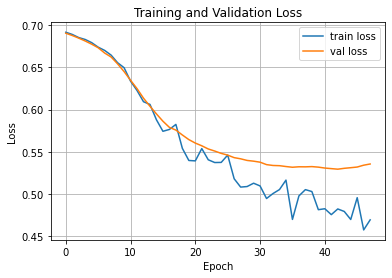

In [39]:
plot_loss(hist)

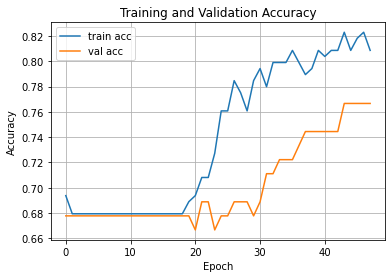

In [40]:
plot_acc(hist)

In [30]:
y_pred_score = best_model.predict(X_val).ravel()
fpr, tpr, thresholds = roc_curve(y_val, y_pred_score)
auc_score=auc(fpr, tpr)

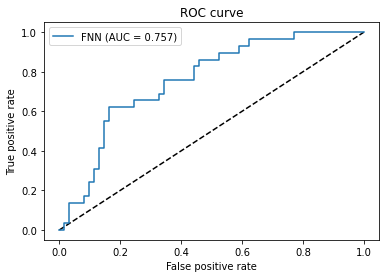

In [31]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='FNN (AUC = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

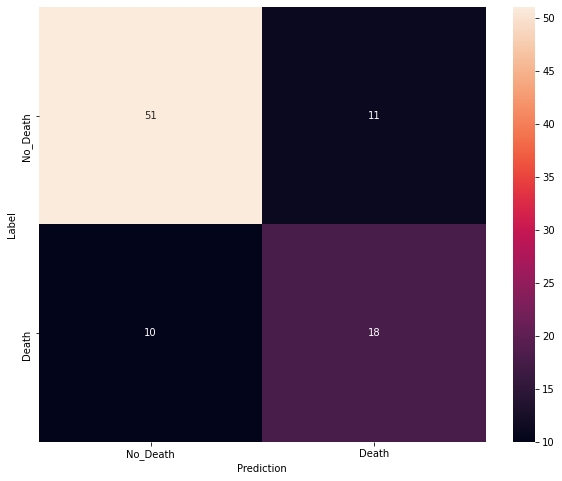

In [46]:
figsize=(6,6)
y_pred=best_model.predict_classes(X_val)
confusion_mtx = tf.math.confusion_matrix(
    y_pred,
    y_val,
    num_classes=2)

show_confusion_matrix(confusion_mtx, ['No_Death', 'Death'])

In [33]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        61
           1       0.64      0.62      0.63        29

    accuracy                           0.77        90
   macro avg       0.73      0.73      0.73        90
weighted avg       0.76      0.77      0.77        90



In [34]:
explainer = shap.DeepExplainer(best_model, X_train)
shap_values = explainer.shap_values(X_val)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


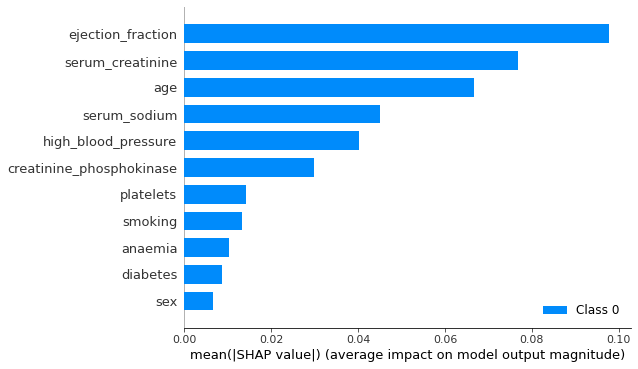

In [41]:
shap.summary_plot(shap_values, features=X_val, feature_names=df.columns)


In [36]:
tuner.oracle.get_best_trials()[0].trial_id

'630ba76abec23c2ebe0e0c643b831eb4'

Erkenntnisse aus dem Hyperparametertuning:
#Smote führt zu sehr schnellem overfitting. Vermutlich, da der synthetisch erzeugte Datensatz zu sehr dem normalen Datensatz ähnelt. 
#Daher muss man mit smote die dropout rate erhöhen bzw. Anzahl der Epochen verkürzen 
#Allerdings bleibt der val loss mit smote sehr vogelwild und val accuracy ist oft höher als train accuracy 
#der Kernel Initializer (also die Gewichtsinitialisierung des NNs) ist sehr wichtig für die Performance. Mit einem uniform initializer wird die Differenz zwischen train_loss und val_loss am stärksten reduziert
#die batch size sollte nicht zu niedrig sein (mehr als 2)